## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [12]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.7)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.7)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.7):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.7):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [13]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [14]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 20)

In [15]:
len(val_dataset)

12913

In [17]:
len(train_dataset)

30128

## Create a DataLoader class for training

In [18]:
from torch import nn, optim

# model
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 32),
            nn.LogSigmoid(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 120),
            nn.LogSigmoid(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [19]:
# model, optimizer, loss
model_encdoc = EncoderDecoder()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [25]:
def train_epochs(model, train_loader, loss_func, opt, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.float()
            preds = model(inp)
            #loss = loss_func(preds, out) # MSE
            loss = torch.sqrt(loss_func(preds, out)) # RMSE

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / len(train_dataset))
    return train_losses

In [26]:
def val_loss(model, val_loader, loss_func, opt):
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        out = out.float()
        preds = model(inp)
        #loss = loss_func(preds, out) # MSE
        loss = torch.sqrt(loss_func(preds, out)) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [29]:
def train_city(city, batch_size, epochs):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = EncoderDecoder()
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_loader, loss_func, opt, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

In [30]:
model_austin, train_losses = train_city('austin', batch_size = 20, epochs = 30)

epoch 0 trian loss: 3.8712503755592755
epoch 1 trian loss: 2.2472606344673776
epoch 2 trian loss: 2.1052226749937772
epoch 3 trian loss: 2.0074980241215363
epoch 4 trian loss: 1.926057252742101
epoch 5 trian loss: 1.7620608127313413
epoch 6 trian loss: 1.6410960385094155
epoch 7 trian loss: 1.5945127769093912
epoch 8 trian loss: 1.464623523689114
epoch 9 trian loss: 1.4166595462909481
epoch 10 trian loss: 1.3592783154101684
epoch 11 trian loss: 1.381533010773246
epoch 12 trian loss: 1.310913631527334
epoch 13 trian loss: 1.31184750288899
epoch 14 trian loss: 1.2676308836888837
epoch 15 trian loss: 1.2426282812861515
epoch 16 trian loss: 1.2153757449736067
epoch 17 trian loss: 1.2087015468771636
epoch 18 trian loss: 1.2303059750013507
epoch 19 trian loss: 1.1511819127133978
epoch 20 trian loss: 1.1244135329334646
epoch 21 trian loss: 1.1432800771261997
epoch 22 trian loss: 1.101648683093421
epoch 23 trian loss: 1.0846772994123997
epoch 24 trian loss: 1.1104078340011267
epoch 25 trian lo

Text(0, 0.5, 'RMSE')

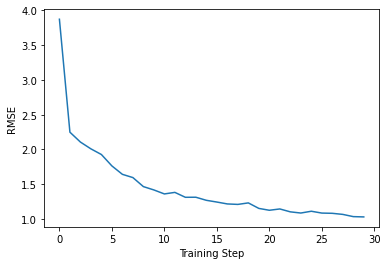

In [36]:
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('RMSE')

In [37]:
val_loss(model_austin, val_loader, loss_func, opt)

val loss: 1.3146179079280154


In [176]:
model_miami, train_losses = train_city('miami', batch_size = 18, epochs = 30)

epoch 0 trian loss: 6401.803402563971
epoch 1 trian loss: 768.6511414222276
epoch 2 trian loss: 319.62873915596106
epoch 3 trian loss: 321.3759631255765
epoch 4 trian loss: 320.65487731166417
epoch 5 trian loss: 262.1034672198853
epoch 6 trian loss: 220.05697251793143
epoch 7 trian loss: 224.08320907777477
epoch 8 trian loss: 209.19176567689001
epoch 9 trian loss: 189.22740657291726
epoch 10 trian loss: 180.82429336069606
epoch 11 trian loss: 173.57667974050747
epoch 12 trian loss: 153.4030981246641
epoch 13 trian loss: 167.85443923676152
epoch 14 trian loss: 134.98629042631475
epoch 15 trian loss: 152.68894639040346
epoch 16 trian loss: 138.38685141755053
epoch 17 trian loss: 125.97099302568438
epoch 18 trian loss: 122.62071852084554
epoch 19 trian loss: 125.66676976816414
epoch 20 trian loss: 117.48509480424154
epoch 21 trian loss: 110.75070813494249
epoch 22 trian loss: 116.62647214113886
epoch 23 trian loss: 109.83087822533527
epoch 24 trian loss: 107.35568654288208
epoch 25 trian 

In [177]:
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 10, epochs = 30)

epoch 0 trian loss: 4910.0210082434205
epoch 1 trian loss: 272.38400228458755
epoch 2 trian loss: 235.36862706594098
epoch 3 trian loss: 203.7011017085357
epoch 4 trian loss: 176.15810602016657
epoch 5 trian loss: 159.4210987285606
epoch 6 trian loss: 142.57819149082653
epoch 7 trian loss: 132.74049480109684
epoch 8 trian loss: 120.84333300300808
epoch 9 trian loss: 113.71307851326476
epoch 10 trian loss: 104.2460804683552
epoch 11 trian loss: 97.53317064906703
epoch 12 trian loss: 90.78260533363911
epoch 13 trian loss: 86.22737686629799
epoch 14 trian loss: 83.67290679136812
epoch 15 trian loss: 78.68139566207158
epoch 16 trian loss: 76.43618753178463
epoch 17 trian loss: 73.11150994126575
epoch 18 trian loss: 69.01241889801703
epoch 19 trian loss: 69.75408965441567
epoch 20 trian loss: 68.12546889738357
epoch 21 trian loss: 66.6433182561246
epoch 22 trian loss: 63.865903346124924
epoch 23 trian loss: 59.70080397132992
epoch 24 trian loss: 59.03269318033585
epoch 25 trian loss: 57.151

In [178]:
model_dearborn, train_losses = train_city('dearborn', batch_size = 35, epochs = 30)

epoch 0 trian loss: 16644.805368652967
epoch 1 trian loss: 49.611448007230294
epoch 2 trian loss: 49.267435935108566
epoch 3 trian loss: 52.96706797597422
epoch 4 trian loss: 62.78010139156015
epoch 5 trian loss: 65.5978205277517
epoch 6 trian loss: 66.87703629481283
epoch 7 trian loss: 66.22388616774467
epoch 8 trian loss: 64.68020094632244
epoch 9 trian loss: 63.41454177366857
epoch 10 trian loss: 62.39289039538608
epoch 11 trian loss: 60.941336895026325
epoch 12 trian loss: 59.90744726100776
epoch 13 trian loss: 58.615013934581
epoch 14 trian loss: 59.29926443681606
epoch 15 trian loss: 56.14922640644422
epoch 16 trian loss: 55.309449397914655
epoch 17 trian loss: 54.889673354410164
epoch 18 trian loss: 54.310374173911754
epoch 19 trian loss: 54.91671447690093
epoch 20 trian loss: 50.956437594795155
epoch 21 trian loss: 51.3681317092301
epoch 22 trian loss: 49.793798652851535
epoch 23 trian loss: 49.000627744192585
epoch 24 trian loss: 49.54314333995765
epoch 25 trian loss: 47.77787

In [179]:
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 20, epochs = 30)

epoch 0 trian loss: 5078.021190643045
epoch 1 trian loss: 60.68644464385157
epoch 2 trian loss: 71.66835994875117
epoch 3 trian loss: 67.94933518702892
epoch 4 trian loss: 63.2911375457061
epoch 5 trian loss: 62.17715359658092
epoch 6 trian loss: 57.804245320209766
epoch 7 trian loss: 56.218275429361
epoch 8 trian loss: 55.9661314930992
epoch 9 trian loss: 56.705059945341
epoch 10 trian loss: 54.16928660369119
epoch 11 trian loss: 50.70138603124124
epoch 12 trian loss: 50.05056812611381
epoch 13 trian loss: 48.05413368476628
epoch 14 trian loss: 46.15345878846578
epoch 15 trian loss: 46.03018449755983
epoch 16 trian loss: 44.53610074426219
epoch 17 trian loss: 42.283925581387194
epoch 18 trian loss: 43.40038165074321
epoch 19 trian loss: 39.57400035302005
epoch 20 trian loss: 39.512716392821446
epoch 21 trian loss: 37.682053590418555
epoch 22 trian loss: 39.19015477404425
epoch 23 trian loss: 34.75343335693796
epoch 24 trian loss: 32.33202687773529
epoch 25 trian loss: 31.9692394064886

In [180]:
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 20, epochs = 30)

epoch 0 trian loss: 1266.9287511312796
epoch 1 trian loss: 34.57949449129673
epoch 2 trian loss: 38.7185149775659
epoch 3 trian loss: 38.14457366731358
epoch 4 trian loss: 38.72149365371644
epoch 5 trian loss: 35.67104416405832
epoch 6 trian loss: 34.99462669973288
epoch 7 trian loss: 32.88418388300227
epoch 8 trian loss: 32.52615688628239
epoch 9 trian loss: 30.351243875241686
epoch 10 trian loss: 30.449641024339893
epoch 11 trian loss: 29.229552982293363
epoch 12 trian loss: 28.6802183566784
epoch 13 trian loss: 24.022090575871243
epoch 14 trian loss: 20.447224517983216
epoch 15 trian loss: 21.138352190234265
epoch 16 trian loss: 19.065866601286828
epoch 17 trian loss: 18.444375770380777
epoch 18 trian loss: 15.051327804005647
epoch 19 trian loss: 19.440579252774153
epoch 20 trian loss: 13.263646914838695
epoch 21 trian loss: 18.381532200350893
epoch 22 trian loss: 14.565159900722271
epoch 23 trian loss: 16.237433625526116
epoch 24 trian loss: 14.49181270158434
epoch 25 trian loss: 1

## Make Prediction

In [181]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [182]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test')[0]
    test_dataset = torch.from_numpy(test_dataset)
    pred = model(test_dataset).reshape(-1, 120)
    return pd.DataFrame(pred.detach().numpy())

In [183]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [184]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out        

In [185]:
test_output = predict_all(cities, models)

In [186]:
test_output.to_csv('test_output.csv', index=False)

In [187]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-10.073917,-566.061401,-8.819520,-565.608826,-11.741660,-566.576843,-11.576724,-565.285645,-12.256501,...,-44.576900,-565.590393,-44.054443,-566.266052,-46.557812,-563.764038,-44.217758,-564.622009,-44.551910,-564.912109
1,1_austin,-342.686127,11.392192,-340.669342,10.488313,-341.599976,11.720736,-341.712524,10.373302,-340.428955,...,-341.368591,-8.623022,-342.578735,-8.707554,-343.319519,-5.805896,-342.187042,-6.541385,-339.858948,-6.626207
2,2_austin,51.151989,-248.709198,51.560665,-248.674286,50.831722,-248.799622,51.387207,-248.906815,51.333149,...,54.076885,-253.501297,54.503571,-253.615631,53.823456,-252.988678,54.417667,-253.362228,54.666046,-253.219437
3,3_austin,-9.816870,1731.381470,-7.283967,1741.485962,-8.684427,1731.078491,-8.787012,1722.190063,-1.411106,...,-18.215618,1685.937256,-25.361523,1678.974365,-15.586805,1677.517578,-18.559374,1676.607666,-25.935057,1675.115967
4,4_austin,1197.461548,-656.045288,1199.759399,-653.736450,1199.970581,-652.724304,1199.894653,-653.054993,1201.510010,...,1233.677002,-664.652954,1233.292358,-664.064331,1232.656738,-666.428833,1233.421143,-666.002869,1233.596680,-665.521423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1416.252808,-492.051514,-1417.608154,-501.115509,-1413.636108,-496.180420,-1413.381348,-496.862274,-1413.135132,...,-1401.196045,-518.820984,-1406.902588,-515.420776,-1401.225098,-511.087738,-1399.512817,-521.496216,-1407.614502,-520.385132
1682,1682_palo-alto,122.822327,-13.106235,121.504395,-13.403252,122.575562,-12.750586,122.367661,-13.090666,122.222778,...,122.844223,-13.603163,123.076660,-13.461958,123.013084,-13.371545,122.435204,-12.216287,122.744949,-12.926801
1683,1683_palo-alto,-1432.258057,2131.601807,-1430.165283,2131.758301,-1435.506470,2128.292480,-1430.843872,2134.353760,-1430.633057,...,-1437.211670,2144.713623,-1436.333862,2147.031982,-1427.991333,2145.734131,-1435.092651,2144.250000,-1436.711670,2148.986328
1684,1684_palo-alto,1096.846069,1392.472046,1097.199585,1392.791870,1097.040039,1391.931519,1098.415039,1395.730347,1092.682129,...,1095.282349,1404.072266,1099.136353,1408.127930,1101.610352,1405.456055,1099.150635,1403.403687,1105.637817,1405.982422


## Sample a batch of data and visualize 

In [52]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 4)

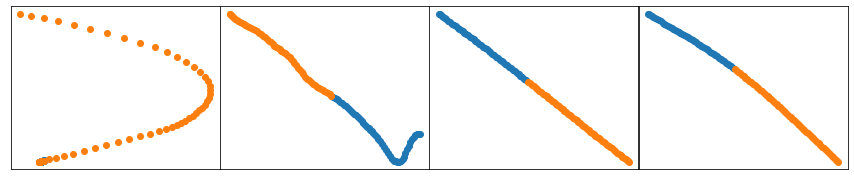

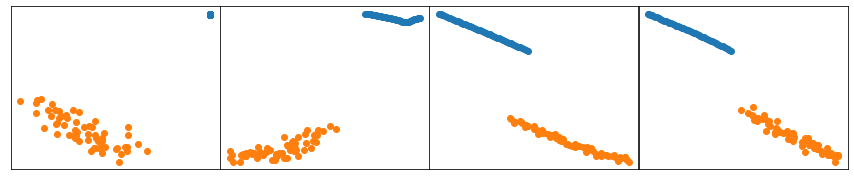

In [61]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    pred = model_austin(inp).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break